In [0]:
%tensorflow_version 2.x

In [4]:
! nvidia-smi

Sat Apr 25 23:17:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     8W /  75W |      0MiB /  7611MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
! wget http://deep.cs.umsl.edu/pdnet/train-data.tar.gz
! tar zxf train-data.tar.gz

--2020-04-25 22:27:10--  http://deep.cs.umsl.edu/pdnet/train-data.tar.gz
Resolving deep.cs.umsl.edu (deep.cs.umsl.edu)... 134.124.28.181
Connecting to deep.cs.umsl.edu (deep.cs.umsl.edu)|134.124.28.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1204288519 (1.1G) [application/x-gzip]
Saving to: ‘train-data.tar.gz’

train-data.tar.gz   100%[===================>]   1.12G  21.4MB/s    in 55s     

2020-04-25 22:28:05 (20.8 MB/s) - ‘train-data.tar.gz’ saved [1204288519/1204288519]



In [0]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis, 1-25-2020
File: Contains subroutines to load input features and output maps
'''

import pickle
import random
import os
import numpy as np
import tensorflow as tf
import numpy as np
epsilon = tf.keras.backend.epsilon()

def load_list(file_lst, max_items = 1000000):
    if max_items < 0:
        max_items = 1000000
    protein_list = []
    f = open(file_lst, 'r')
    for l in f.readlines():
        protein_list.append(l.strip().split()[0])
    if (max_items < len(protein_list)):
        protein_list = protein_list[:max_items]
    return protein_list

def summarize_channels(x, y):
    print(' Channel        Avg        Max        Sum')
    for i in range(len(x[0, 0, :])):
        (m, s, a) = (x[:, :, i].flatten().max(), x[:, :, i].flatten().sum(), x[:, :, i].flatten().mean())
        print(' %7s %10.4f %10.4f %10.1f' % (i+1, a, m, s))
    print("      Ymin = %.2f  Ymean = %.2f  Ymax = %.2f" % (y.min(), y.mean(), y.max()) )

def get_bulk_output_contact_maps(pdb_id_list, all_dist_paths, OUTL):
    YY = np.full((len(pdb_id_list), OUTL, OUTL, 1), 100.0)
    for i, pdb in enumerate(pdb_id_list):
        Y = get_map(pdb, all_dist_paths)
        ly = len(Y[:, 0])
        assert ly <= OUTL
        YY[i, :ly, :ly, 0] = Y
    if np.any(np.isnan(Y)):
        print('')
        print('WARNING:')
        print('Some pdbs in the following list have NaNs in their distances:', pdb_id_list)
        np.seterr(invalid='ignore')
    YY[ YY < 8.0 ] = 1.0
    YY[ YY >= 8.0 ] = 0.0
    return YY.astype(np.float32)

def get_bulk_output_dist_maps(pdb_id_list, all_dist_paths, OUTL):
    YY = np.full((len(pdb_id_list), OUTL, OUTL, 1), np.inf)
    for i, pdb in enumerate(pdb_id_list):
        Y = get_map(pdb, all_dist_paths)
        ly = len(Y[:, 0])
        assert ly <= OUTL
        YY[i, :ly, :ly, 0] = Y
    return YY.astype(np.float32)

def get_input_output_dist(pdb_id_list, all_feat_paths, all_dist_paths, pad_size, OUTL, expected_n_channels):
    XX = np.full((len(pdb_id_list), OUTL, OUTL, expected_n_channels), 0.0)
    YY = np.full((len(pdb_id_list), OUTL, OUTL, 1), 100.0)
    for i, pdb in enumerate(pdb_id_list):
        X = get_feature(pdb, all_feat_paths, expected_n_channels)
        assert len(X[0, 0, :]) == expected_n_channels
        Y0 = get_map(pdb, all_dist_paths, len(X[:, 0, 0]))
        assert len(X[:, 0, 0]) >= len(Y0[:, 0])
        if len(X[:, 0, 0]) != len(Y0[:, 0]):
            print('')
            print('WARNING!! Different len(X) and len(Y) for ', pdb, len(X[:, 0, 0]), len(Y0[:, 0]))
        l = len(X[:, 0, 0])
        Y = np.full((l, l), np.nan)
        Y[:len(Y0[:, 0]), :len(Y0[:, 0])] = Y0
        Xpadded = np.zeros((l + pad_size, l + pad_size, len(X[0, 0, :])), dtype=np.float32)
        Xpadded[int(pad_size/2) : l+int(pad_size/2), int(pad_size/2) : l+int(pad_size/2), :] = X
        Ypadded = np.full((l + pad_size, l + pad_size), 100.0, dtype=np.float32)
        Ypadded[int(pad_size/2) : l+int(pad_size/2), int(pad_size/2) : l+int(pad_size/2)] = Y
        l = len(Xpadded[:, 0, 0])
        if l <= OUTL:
            XX[i, :l, :l, :] = Xpadded
            YY[i, :l, :l, 0] = Ypadded
        else:
            rx = random.randint(0, l - OUTL)
            ry = random.randint(0, l - OUTL)
            assert rx + OUTL <= l
            assert ry + OUTL <= l
            XX[i, :, :, :] = Xpadded[rx:rx+OUTL, ry:ry+OUTL, :]
            YY[i, :, :, 0] = Ypadded[rx:rx+OUTL, ry:ry+OUTL]
    return XX.astype(np.float32), YY.astype(np.float32)

def get_input_output_bins(pdb_id_list, all_feat_paths, all_dist_paths, pad_size, OUTL, expected_n_channels, bins):
    XX = np.full((len(pdb_id_list), OUTL, OUTL, expected_n_channels), 0.0)
    YY = np.full((len(pdb_id_list), OUTL, OUTL, len(bins)), 0.0)
    for i, pdb in enumerate(pdb_id_list):
        X = get_feature(pdb, all_feat_paths, expected_n_channels)
        assert len(X[0, 0, :]) == expected_n_channels
        Y0 = dist_map_to_bins(get_map(pdb, all_dist_paths, len(X[:, 0, 0])), bins)
        assert len(X[:, 0, 0]) >= len(Y0[:, 0])
        if len(X[:, 0, 0]) != len(Y0[:, 0]):
            print('')
            print('WARNING!! Different len(X) and len(Y) for ', pdb, len(X[:, 0, 0]), len(Y0[:, 0]))
        l = len(X[:, 0, 0])
        Y = np.full((l, l, len(Y0[0, 0, :])), np.nan)
        Y[:len(Y0[:, 0]), :len(Y0[:, 0]), :] = Y0
        Xpadded = np.zeros((l + pad_size, l + pad_size, len(X[0, 0, :])))
        Xpadded[int(pad_size/2) : l+int(pad_size/2), int(pad_size/2) : l+int(pad_size/2), :] = X
        Ypadded = np.full((l + pad_size, l + pad_size, len(bins)), 0.0)
        Ypadded[int(pad_size/2) : l+int(pad_size/2), int(pad_size/2) : l+int(pad_size/2), :] = Y
        l = len(Xpadded[:, 0, 0])
        if l <= OUTL:
            XX[i, :l, :l, :] = Xpadded
            YY[i, :l, :l, :] = Ypadded
        else:
            rx = random.randint(0, l - OUTL)
            ry = random.randint(0, l - OUTL)
            assert rx + OUTL <= l
            assert ry + OUTL <= l
            XX[i, :, :, :] = Xpadded[rx:rx+OUTL, ry:ry+OUTL, :]
            YY[i, :, :, :] = Ypadded[rx:rx+OUTL, ry:ry+OUTL, :]
    return XX.astype(np.float32), YY.astype(np.float32)

def get_sequence(pdb, feature_file):
    features = pickle.load(open(feature_file, 'rb'))
    return features['seq']

def get_feature(pdb, all_feat_paths, expected_n_channels):
    features = None
    for path in all_feat_paths:
        if os.path.exists(path + pdb + '.pkl'):
            features = pickle.load(open(path + pdb + '.pkl', 'rb'))
    if features == None:
        print('Expected feature file for', pdb, 'not found at', all_feat_paths)
        exit(1)
    l = len(features['seq'])
    seq = features['seq']
    # Create X and Y placeholders
    X = np.full((l, l, expected_n_channels), 0.0)
    # Add secondary structure
    ss = features['ss']
    assert ss.shape == (3, l)
    fi = 0
    for j in range(3):
        a = np.repeat(ss[j].reshape(1, l), l, axis = 0)
        X[:, :, fi] = a
        fi += 1
        X[:, :, fi] = a.T
        fi += 1
    # Add PSSM
    pssm = features['pssm']
    assert pssm.shape == (l, 22)
    for j in range(22):
        a = np.repeat(pssm[:, j].reshape(1, l), l, axis = 0)
        X[:, :, fi] = a
        fi += 1
        X[:, :, fi] = a.T
        fi += 1
    # Add SA
    sa = features['sa']
    assert sa.shape == (l, )
    a = np.repeat(sa.reshape(1, l), l, axis = 0)
    X[:, :, fi] = a
    fi += 1
    X[:, :, fi] = a.T
    fi += 1
    # Add entrophy
    entropy = features['entropy']
    assert entropy.shape == (l, )
    a = np.repeat(entropy.reshape(1, l), l, axis = 0)
    X[:, :, fi] = a
    fi += 1
    X[:, :, fi] = a.T
    fi += 1
    # Add CCMpred
    ccmpred = features['ccmpred']
    assert ccmpred.shape == ((l, l))
    X[:, :, fi] = ccmpred
    fi += 1
    # Add  FreeContact
    freecon = features['freecon']
    assert freecon.shape == ((l, l))
    X[:, :, fi] = freecon
    fi += 1
    # Add potential
    potential = features['potential']
    assert potential.shape == ((l, l))
    X[:, :, fi] = potential
    fi += 1
    assert fi == expected_n_channels
    assert X.max() < 100.0
    assert X.min() > -100.0
    return X

def get_map(pdb, all_dist_paths, expected_l = -1):
    seqy = None
    mypath = ''
    for path in all_dist_paths:
        if os.path.exists(path + pdb + '-cb.npy'):
            mypath = path + pdb + '-cb.npy'
            (ly, seqy, cb_map) = np.load(path + pdb + '-cb.npy', allow_pickle = True)
    if seqy == None:
        print('Expected distance map file for', pdb, 'not found at', all_dist_paths)
        exit(1)
    if 'cameo' not in mypath and expected_l > 0:
        assert expected_l == ly
        assert cb_map.shape == ((expected_l, expected_l))
    Y = cb_map
    # Only CAMEO dataset has this issue
    if 'cameo' not in mypath:
        assert not np.any(np.isnan(Y))
    if np.any(np.isnan(Y)):
        np.seterr(invalid='ignore')
        print('')
        print('WARNING!! Some values in the pdb structure of', pdb, 'l = ', ly, 'are missing or nan! Indices are: ', np.where(np.isnan(np.diagonal(Y))))
    Y[Y < 1.0] = 1.0
    Y[0, 0] = Y[0, 1]
    Y[ly-1, ly-1] = Y[ly-1, ly-2]
    for q in range(1, ly-1):
        if np.isnan(Y[q, q]):
            continue
        if np.isnan(Y[q, q-1]) and np.isnan(Y[q, q+1]):
            Y[q, q] = 1.0
        elif np.isnan(Y[q, q-1]):
            Y[q, q] = Y[q, q+1]
        elif np.isnan(Y[q, q+1]):
            Y[q, q] = Y[q, q-1]
        else:
            Y[q, q] = (Y[q, q-1] + Y[q, q+1]) / 2.0
    assert np.nanmax(Y) <= 500.0
    assert np.nanmin(Y) >= 1.0
    return Y

def save_dist_rr(pdb, pred_matrix, feature_file, file_rr):
    sequence = get_sequence(pdb, feature_file)
    rr = open(file_rr, 'w')
    rr.write(sequence + "\n")
    P = np.copy(pred_matrix)
    L = len(P[:])
    for j in range(0, L):
        for k in range(j, L):
            P[j, k] = (P[k, j, 0] + P[j, k, 0]) / 2.0
    for j in range(0, L):
        for k in range(j, L):
            if abs(j - k) < 5:
                continue
            rr.write("%i %i %0.3f %.3f 1\n" %(j+1, k+1, P[j][k], P[j][k]) )
    rr.close()
    print('Written RR ' + file_rr + ' !')

def save_contacts_rr(pdb, all_feat_paths, pred_matrix, file_rr):
    for path in all_feat_paths:
        if os.path.exists(path + pdb + '.pkl'):
            features = pickle.load(open(path + pdb + '.pkl', 'rb'))
    if features == None:
        print('Expected feature file for', pdb, 'not found at', all_feat_paths)
        exit(1)
    sequence = features['seq']
    rr = open(file_rr, 'w')
    rr.write(sequence + "\n")
    P = np.copy(pred_matrix)
    L = len(P[:])
    for j in range(0, L):
        for k in range(j, L):
            P[j, k] = (P[k, j, 0] + P[j, k, 0]) / 2.0
    for j in range(0, L):
        for k in range(j, L):
            if abs(j - k) < 5:
                continue
            rr.write("%i %i 0 8 %.5f\n" %(j+1, k+1, (P[j][k])) )
    rr.close()
    print('Written RR ' + file_rr + ' !')

def dist_map_to_bins(Y, bins):
    L = len(Y[:, 0])
    B = np.full((L, L, len(bins)), 0)
    for i in range(L):
        for j in range(L):
            for bin_i, bin_range in bins.items():
                min_max = [float(x) for x in bin_range.split()]
                if Y[i, j] > min_max[0] and Y[i, j] <= min_max[1]:
                    B[i, j, bin_i] = 1
    return B


In [0]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis, 12-18-2019
File: Contains the code to "generate" protein I/O using data generators
'''

from tensorflow.keras.utils import *
#from dataio import *
import tensorflow as tf
epsilon = tf.keras.backend.epsilon()

class ContactGenerator(Sequence):
    def __init__(self, pdb_id_list, features_path, distmap_path, dim, pad_size, batch_size, expected_n_channels):
        self.pdb_id_list = pdb_id_list
        self.features_path = features_path
        self.dim = dim
        self.pad_size = pad_size
        self.distmap_path = distmap_path
        self.batch_size = batch_size
        self.expected_n_channels = expected_n_channels

    def on_epoch_begin(self):
        self.indexes = np.arange(len(self.pdb_id_list))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(len(self.pdb_id_list) / self.batch_size)

    def __getitem__(self, index):
        batch_list = self.pdb_id_list[index * self.batch_size: (index + 1) * self.batch_size]
        X, Y = get_input_output_dist(batch_list, self.features_path, self.distmap_path, self.pad_size, self.dim, self.expected_n_channels)
        Y[ Y < 8.0  ] = 1.0
        Y[ Y >= 8.0 ] = 0.0
        return X, Y

class BinnedDistGenerator(Sequence):
    def __init__(self, pdb_id_list, features_path, distmap_path, bins, dim, pad_size, batch_size, expected_n_channels):
        self.pdb_id_list = pdb_id_list
        self.features_path = features_path
        self.dim = dim
        self.pad_size = pad_size
        self.distmap_path = distmap_path
        self.bins = bins
        self.batch_size = batch_size
        self.expected_n_channels = expected_n_channels

    def on_epoch_begin(self):
        self.indexes = np.arange(len(self.pdb_id_list))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(len(self.pdb_id_list) / self.batch_size)

    def __getitem__(self, index):
        batch_list = self.pdb_id_list[index * self.batch_size: (index + 1) * self.batch_size]
        X, Y = get_input_output_bins(batch_list, self.features_path, self.distmap_path, self.pad_size, self.dim, self.expected_n_channels, self.bins)
        return X, Y

class DistGenerator(Sequence):
    def __init__(self, pdb_id_list, features_path, distmap_path, dim, pad_size, batch_size, expected_n_channels):
        self.pdb_id_list = pdb_id_list
        self.features_path = features_path
        self.distmap_path = distmap_path
        self.dim = dim
        self.pad_size = pad_size
        self.batch_size = batch_size
        self.expected_n_channels = expected_n_channels

    def on_epoch_begin(self):
        self.indexes = np.arange(len(self.pdb_id_list))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(len(self.pdb_id_list) / self.batch_size)

    def __getitem__(self, index):
        batch_list = self.pdb_id_list[index * self.batch_size: (index + 1) * self.batch_size]
        X, Y = get_input_output_dist(batch_list, self.features_path, self.distmap_path, self.pad_size, self.dim, self.expected_n_channels)
        return X, 100.0 / (Y + epsilon)



In [7]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis, 12-18-2019
File: Contains subroutines to visualize the inputs and predictions
'''

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np

def plot_protein_io(X, Y):
    figure(num=None, figsize=(20, 58), dpi=80, facecolor='w', frameon=True, edgecolor='k')
    print('')
    print('Generating seaborn plots.. patience..')
    for i in range(0, len(X[0, 0, :])):
        plt.subplot(15, 4, i + 1)
        sns.heatmap(X[:, :, i], cmap='RdYlBu')
        plt.title('Channel ' + str(i))
    plt.subplot(15, 4, len(X[0, 0, :]) + 1)
    plt.grid(None)
    y = np.copy(Y)
    y[y > 25.0] = 25.0
    sns.heatmap(y, cmap='Spectral')
    plt.title('True Distances')
    plt.show()

def plot_learning_curves(history):
    print('')
    print('Curves..')
    print(history.params)
    plt.clf()
    if 'mean_absolute_error' in history.history:
        plt.plot(history.history['mean_absolute_error'], 'g', label = 'Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], 'b', label = 'Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
    elif 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], 'g', label = 'Training Accuracy')
        plt.plot(history.history['val_accuracy'], 'b', label = 'Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
    else:
        plt.plot(history.history['mae'], 'g', label = 'Training MAE')
        plt.plot(history.history['val_mae'], 'b', label = 'Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
    plt.legend()
    plt.show()

def plot_four_pair_maps(T, P, pdb_list, length_dict):
    figure(num=None, figsize=(24, 10), dpi=60, facecolor='w', frameon=True, edgecolor='k')
    I = 1
    for k in range(4):
        L = length_dict[pdb_list[k]]
        plt.subplot(2, 4, I)
        I += 1
        sns.heatmap(T[k, 0:L, 0:L, 0], cmap='Spectral')
        plt.title('True - ' + pdb_list[k])
    for k in range(4):
        L = length_dict[pdb_list[k]]
        plt.subplot(2, 4, I)
        I += 1
        sns.heatmap(P[k, 0:L, 0:L, 0], cmap='Spectral')
        plt.title('Prediction - ' + pdb_list[k])
    plt.show()

def plot_channel_histograms(X):
    for i in range(len(x[0, 0, :])):
        print ('Input feature', i)
        plt.hist(x[:, :, i].flatten())
        plt.show()
    print('Output labels')
    plt.hist(y.flatten())
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis, 1-26-2020
File: Contains the metrics to evaluate predicted real-valued distances, binned-distances and contact maps
'''

import numpy as np
import tensorflow as tf
epsilon = tf.keras.backend.epsilon()

'''
from dataio import *
from plots import *
from generator import *
'''

def calculate_mae(PRED, YTRUE, pdb_list, length_dict):
    mae_lr_d8_list = np.zeros(len(PRED[:, 0, 0, 0]))
    mae_mlr_d8_list = np.zeros(len(PRED[:, 0, 0, 0]))
    mae_lr_d12_list = np.zeros(len(PRED[:, 0, 0, 0]))
    mae_mlr_d12_list = np.zeros(len(PRED[:, 0, 0, 0]))
    for i in range(0, len(PRED[:, 0, 0, 0])):
        L = length_dict[pdb_list[i]]
        PAVG = np.full((L, L), 100.0)
        # Average the predictions from both triangles
        for j in range(0, L):
            for k in range(j, L):
                PAVG[j, k] = (PRED[i, k, j, 0] + PRED[i, j, k, 0]) / 2.0
        # at distance 8 and separation 24
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        P = np.copy(PAVG)
        for p in range(len(Y)):
            for q in range(len(Y)):
                if q - p < 24:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
                    continue
                if Y[p, q] > 8:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
        mae_lr_d8 = np.nan
        if not np.isnan(np.abs(Y - P)).all():
            mae_lr_d8 = np.nanmean(np.abs(Y - P))
            #mae_lr_d8 = np.sqrt(np.nanmean(np.abs(Y - P) ** 2))
        # at distance 8 and separation 12
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        P = np.copy(PAVG)
        for p in range(len(Y)):
            for q in range(len(Y)):
                if q - p < 12:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
                    continue
                if Y[p, q] > 8:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
        mae_mlr_d8 = np.nan
        if not np.isnan(np.abs(Y - P)).all():
            mae_mlr_d8 = np.nanmean(np.abs(Y - P))
        # at distance 12 and separation 24
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        P = np.copy(PAVG)
        for p in range(len(Y)):
            for q in range(len(Y)):
                if q - p < 24:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
                    continue
                if Y[p, q] > 12:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
        mae_lr_d12 = np.nan
        if not np.isnan(np.abs(Y - P)).all():
            mae_lr_d12 = np.nanmean(np.abs(Y - P))
        # at distance 12 and separation 12
        Y = np.copy(YTRUE[i, 0:L, 0:L, 0])
        P = np.copy(PAVG)
        for p in range(len(Y)):
            for q in range(len(Y)):
                if q - p < 12:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
                    continue
                if Y[p, q] > 12:
                    Y[p, q] = np.nan
                    P[p, q] = np.nan
        mae_mlr_d12 = np.nan
        if not np.isnan(np.abs(Y - P)).all():
            mae_mlr_d12 = np.nanmean(np.abs(Y - P))
        # add to list
        mae_lr_d8_list[i] = mae_lr_d8
        mae_mlr_d8_list[i] = mae_mlr_d8
        mae_lr_d12_list[i] = mae_lr_d12
        mae_mlr_d12_list[i] = mae_mlr_d12
        print('MAE for ' + str(i) + ' ' + str(pdb_list[i]) + ' lr_d8 = %.2f  mlr_d8 = %.2f  lr_d12 = %.2f  mlr_d12 = %.2f' % (mae_lr_d8, mae_mlr_d8, mae_lr_d12, mae_mlr_d12))
    print('Average MAE      : lr<8A = %.4f  mlr<8A = %.4f  lr<12A = %.4f  mlr<12A = %.4f' % (np.nanmean(mae_lr_d8_list), np.nanmean(mae_mlr_d8_list), np.nanmean(mae_lr_d12_list), np.nanmean(mae_mlr_d12_list)))

# Convert distances to contact probabilities
def distance_to_contacts(distance_matrix):
    P = 4.0 / distance_matrix
    P[P > 1.0] = 1.0
    return P

def calculate_contact_precision_in_distances(PRED, YTRUE, pdb_list, length_dict):
    Y = np.copy(YTRUE)
    Y[ Y < 8.0] = True
    Y[ Y >= 8.0] = False
    calculate_contact_precision(distance_to_contacts(PRED), Y, pdb_list, length_dict)

def calculate_contact_precision(PRED, YTRUE, pdb_list, length_dict):
    avg_p_lr_topL5 = 0.0
    avg_p_lr_topL = 0.0
    avg_p_lr_topNc = 0.0
    avg_p_mlr_topL5 = 0.0
    avg_p_mlr_topL = 0.0
    avg_p_mlr_topNc = 0.0
    count_pdbs_with_lr = 0
    count_pdbs_with_mlr = 0
    for i in range(0, len(PRED[:, 0, 0, 0])):
        # Ideally: L = length_dict[pdb_list[i]], but L should be # of valid residues in structure
        L = length_dict[pdb_list[i]]
        LPDB = len(np.where(~np.isnan(np.diagonal(YTRUE[i, :L, :L, 0])))[0])
        P = np.full((L, L), 0.0)
        # Average the predictions from both triangles
        for j in range(0, L):
            for k in range(j, L):
                P[j, k] = (PRED[i, k, j, 0] + PRED[i, j, k, 0]) / 2.0
        p_dict = {}
        for j in range(0, L):
            for k in range(j, L):
                if np.isnan(YTRUE[i, j, k, 0]):
                    continue
                p_dict[(j,k)] = P[j, k]

        p_lr_topNc = float('nan')
        p_lr_topL = float('nan')
        p_lr_topL5 = float('nan')
        p_mlr_topNc = float('nan')
        p_mlr_topL = float('nan')
        p_mlr_topL5 = float('nan')

        # Check if there are 0 medium-long-range contacts
        total_true_mlr = 0
        for j in range(0, L):
            for k in range(j, L):
                if (abs(j-k) < 12):
                    continue
                if np.isnan(YTRUE[i, k, j]):
                    continue
                if YTRUE[i, k, j]:
                    total_true_mlr += 1
        # Check if there are 0 long-range contacts
        total_true_lr = 0
        for j in range(0, L):
            for k in range(j, L):
                if (abs(j-k) < 24):
                    continue
                if np.isnan(YTRUE[i, k, j]):
                    continue
                if YTRUE[i, k, j]:
                    total_true_lr += 1

        if total_true_mlr > 0:
            # Top Nc (all) medium- and long-range distances
            p_mlr_topNc = 0
            x = total_true_mlr
            total_predictions = 0
            for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                (k, v) = pair
                (p, q) = k
                if (abs(p-q) < 12):
                    continue
                if YTRUE[i, p, q]:
                    p_mlr_topNc += 1
                total_predictions += 1
                x -= 1
                if x == 0:
                    break
            p_mlr_topNc /= total_predictions
            # Top L medium- and long-range distances
            p_mlr_topL = 0
            x = LPDB
            total_predictions = 0
            for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                (k, v) = pair
                (p, q) = k
                if (abs(p-q) < 12):
                    continue
                if YTRUE[i, p, q]:
                    p_mlr_topL += 1
                total_predictions += 1
                x -= 1
                if x == 0:
                    break
            p_mlr_topL /= total_predictions
            # Top L/5 medium- and long-range distances
            p_mlr_topL5 = 0
            x = int(round(LPDB/5))
            total_predictions = 0
            for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                (k, v) = pair
                (p, q) = k
                if (abs(p-q) < 12):
                    continue
                if YTRUE[i, p, q]:
                    p_mlr_topL5 += 1
                total_predictions += 1
                x -= 1
                if x == 0:
                    break
            p_mlr_topL5 /= total_predictions

            if total_true_lr > 0:
                # Top Nc (all) long-range distances
                p_lr_topNc = 0
                x = total_true_lr
                total_predictions = 0
                for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                    (k, v) = pair
                    (p, q) = k
                    if (abs(p-q) < 24):
                        continue
                    if YTRUE[i, p, q]:
                        p_lr_topNc += 1
                    total_predictions += 1
                    x -= 1
                    if x == 0:
                        break
                p_lr_topNc /= total_predictions
                # Top L long-range distances
                p_lr_topL = 0
                x = LPDB
                total_predictions = 0
                for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                    (p, q) = pair[0]
                    if abs(p-q) < 24:
                        continue
                    if YTRUE[i, p, q] == 1.0:
                        p_lr_topL += 1
                    total_predictions += 1
                    x -= 1
                    if x == 0:
                        break

                p_lr_topL /= total_predictions
                # Top L/5 long-range distances
                p_lr_topL5 = 0
                x = int(round(LPDB/5))
                total_predictions = 0
                for pair in reversed(sorted(p_dict.items(), key=lambda x: x[1])):
                    (k, v) = pair
                    (p, q) = k
                    if (abs(p-q) < 24):
                        continue
                    if YTRUE[i, p, q]:
                        p_lr_topL5 += 1
                    total_predictions += 1
                    x -= 1
                    if x == 0:
                        break
                p_lr_topL5 /= total_predictions
                # Average for all pdbs
                avg_p_lr_topL5 += p_lr_topL5
                avg_p_lr_topL += p_lr_topL
                avg_p_lr_topNc += p_lr_topNc
                avg_p_mlr_topL5 += p_mlr_topL5
                avg_p_mlr_topL += p_mlr_topL
                avg_p_mlr_topNc += p_mlr_topNc
                count_pdbs_with_lr += 1
            count_pdbs_with_mlr += 1
        print('Precision for ' + str(i) + ' - ' + str(pdb_list[i]) + '  top_L5_lr = %.4f  top_L_lr = %.4f  top_Nc_lr = %.4f  top_L5_mlr = %.4f  top_L_mlr = %.4f  top_Nc_mlr = %.4f (total_true_lr = %d  total_true_mlr = %d)' % (p_lr_topL5, p_lr_topL, p_lr_topNc, p_mlr_topL5, p_mlr_topL, p_mlr_topNc, total_true_lr, total_true_mlr) )
    print('Average Precision: top_L5_lr = %.2f  top_L_lr = %.2f  top_Nc_lr = %.2f  top_L5_mlr = %.2f  top_L_mlr = %.2f  top_Nc_mlr = %.2f' %
          (100.0 * avg_p_lr_topL5 / count_pdbs_with_lr,
           100.0 * avg_p_lr_topL / count_pdbs_with_lr,
           100.0 * avg_p_lr_topNc / count_pdbs_with_lr,
           100.0 * avg_p_mlr_topL5 / count_pdbs_with_mlr,
           100.0 * avg_p_mlr_topL / count_pdbs_with_mlr,
           100.0 * avg_p_mlr_topNc / count_pdbs_with_mlr))

def eval_distance_predictions(my_model, my_list, my_length_dict, my_dir_features, my_dir_distance, pad_size, flag_plots, flag_save, LMAX, expected_n_channels):
    # Padded but full inputs/outputs
    my_generator = DistGenerator(my_list, my_dir_features, my_dir_distance, LMAX, pad_size, 1, expected_n_channels)
    P = my_model.predict_generator(my_generator, max_queue_size=10, verbose=1)
    P[ P < 0.01 ] = 0.01
    P = 100.0 / (P + epsilon)
    # Remove padding, i.e. shift up and left by int(pad_size/2)
    P[:, :LMAX-pad_size, :LMAX-pad_size, :] = P[:, int(pad_size/2) : LMAX-int(pad_size/2), int(pad_size/2) : LMAX-int(pad_size/2), :]
    Y = get_bulk_output_dist_maps(my_list, my_dir_distance, LMAX)

    if flag_plots:
        plot_four_pair_maps(Y, P, my_list, my_length_dict)

    print('')
    calculate_mae(P, Y, my_list, my_length_dict)

    print('')
    calculate_contact_precision_in_distances(P, Y, my_list, my_length_dict)

    if flag_save:
        os.system('mkdir -p ./predictions')
        print('')
        print('Save predictions..')
        for i in range(len(my_list)):
            L = my_length_dict[my_list[i]]
            pred = P[i, :L, :L]
            save_contacts_rr(my_list[i], my_dir_features, distance_to_contacts(pred), './predictions/' + my_list[i] + '.4bydist.rr')

def eval_contact_predictions(my_model, my_list, my_length_dict, my_dir_features, my_dir_distance, pad_size, flag_plots, flag_save, LMAX, expected_n_channels):
    # Padded but full inputs/outputs
    my_generator = ContactGenerator(my_list, my_dir_features, my_dir_distance, LMAX, pad_size, 1, expected_n_channels)
    P = my_model.predict_generator(my_generator, max_queue_size=10, verbose=1)
    # Remove padding, i.e. shift up and left by int(pad_size/2)
    P[:, :LMAX-pad_size, :LMAX-pad_size, :] = P[:, int(pad_size/2) : LMAX-int(pad_size/2), int(pad_size/2) : LMAX-int(pad_size/2), :]
    Y = get_bulk_output_contact_maps(my_list, my_dir_distance, LMAX)

    if flag_plots:
        plot_four_pair_maps(Y, P, my_list, my_length_dict)

    print('')
    calculate_contact_precision(P, Y, my_list, my_length_dict)

    if flag_save:
        os.system('mkdir -p ./predictions')
        print('')
        print('Save predictions..')
        for i in range(len(my_list)):
            L = my_length_dict[my_list[i]]
            pred = P[i, :L, :L]
            save_contacts_rr(my_list[i], my_dir_features, pred, './predictions/' + my_list[i] + '.contacts.rr')

def eval_binned_predictions(my_model, my_list, my_length_dict, my_dir_features, my_dir_distance, pad_size, flag_plots, flag_save, LMAX, bins, expected_n_channels):
    # Padded but full inputs/outputs
    my_generator = BinnedDistGenerator(my_list, my_dir_features, my_dir_distance, bins, LMAX, pad_size, 1, expected_n_channels)
    P = my_model.predict_generator(my_generator, max_queue_size=10, verbose=1)
    # Remove padding, i.e. shift up and left by int(pad_size/2)
    P[:, :LMAX-pad_size, :LMAX-pad_size, :] = P[:, int(pad_size/2) : LMAX-int(pad_size/2), int(pad_size/2) : LMAX-int(pad_size/2), :]
    Y = get_bulk_output_contact_maps(my_list, my_dir_distance, LMAX)

    # Predicted distance is mean distance of the most confident bin
    D = np.zeros((len(P), LMAX, LMAX, 1))
    for p in range(len(P)):
        for i in range(LMAX):
            for j in range(LMAX):
                index = np.argmax(P[p, i, j, :])
                min_max = [float(x) for x in bins[index].split()]
                D[p, i, j, 0] = ( min_max[0] + min_max[1] ) / 2.0

    # The last bin's range has a very large value, so trim it
    bin_max = float(bins[len(bins) - 1].split()[0])
    D[D > bin_max] = bin_max

    Y = get_bulk_output_dist_maps(my_list, my_dir_distance, LMAX)

    print('')
    calculate_mae(D, Y, my_list, my_length_dict)

    # Identify the bins that fall under the 8.0A distance
    contact_bins = -1
    for k, v in bins.items():
        if bins[k].split()[0] == '8.0':
            contact_bins = k

    # Sum the probabilities of the bins that fall under 8.0A distance
    C = np.zeros((len(P), LMAX, LMAX, 1))
    for p in range(len(P)):
        for i in range(LMAX):
            for j in range(LMAX):
                C[p, i, j, 0] = np.sum(P[p, i, j, :contact_bins])

    Y = get_bulk_output_contact_maps(my_list, my_dir_distance, LMAX)

    print('')
    calculate_contact_precision(C, Y, my_list, my_length_dict)

    if flag_save:
        os.system('mkdir -p ./predictions')
        print('')
        print('Save predictions..')
        for i in range(len(my_list)):
            L = my_length_dict[my_list[i]]
            predictions = {}
            for b in range(len(bins)):
                predictions[bins[b]] = P[i, :L, :L, b].astype(np.float16)
            f = open('./predictions/' + my_list[i] + '.bins.pkl', 'wb')
            pickle.dump(predictions, f)
            f.close()


In [0]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis, 12-18-2019
File: Contains tensorflow models for the DEEPCON architecture
'''

import tensorflow as tf
from tensorflow.python.keras import layers

from tensorflow.python.keras.layers import Input, Convolution2D, Activation, add, Dropout, BatchNormalization
from tensorflow.python.keras.models import Model

# A basic fully convolutional network
def basic_fcn(L, num_blocks, width, expected_n_channels):
    input_shape = (L, L, expected_n_channels)
    img_input = layers.Input(shape = input_shape)
    x = img_input
    for i in range(num_blocks):
        x = layers.Conv2D(width, (3, 3), padding = 'same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
    x = layers.Conv2D(1, (3, 3), padding = 'same', kernel_initializer = 'one')(x)
    x = layers.Activation('relu')(x)
    inputs = img_input
    model = tf.keras.models.Model(inputs, x, name = 'fcn')
    return model

# Architecture DEEPCON (original)
def deepcon_rdd(L, num_blocks, width, expected_n_channels):
    print('')
    print('Model params:')
    print('L', L)
    print('num_blocks', num_blocks)
    print('width', width)
    print('expected_n_channels', expected_n_channels)
    print('')
    dropout_value = 0.3
    my_input = Input(shape = (L, L, expected_n_channels))
    tower = BatchNormalization()(my_input)
    tower = Activation('relu')(tower)
    tower = Convolution2D(width, 1, padding = 'same')(tower)
    n_channels = width
    d_rate = 1
    for i in range(num_blocks):
        block = BatchNormalization()(tower)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), padding = 'same')(block)
        block = Dropout(dropout_value)(block)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), dilation_rate=(d_rate, d_rate), padding = 'same')(block)
        tower = add([block, tower])
        if d_rate == 1:
            d_rate = 2
        elif d_rate == 2:
            d_rate = 4
        else:
            d_rate = 1
    tower = BatchNormalization()(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(1, 3, padding = 'same')(tower)
    tower = Activation('sigmoid')(tower)
    model = Model(my_input, tower)
    return model

# Architecture DEEPCON (distances)
def deepcon_rdd_distances(L, num_blocks, width, expected_n_channels):
    print('')
    print('Model params:')
    print('L', L)
    print('num_blocks', num_blocks)
    print('width', width)
    print('expected_n_channels', expected_n_channels)
    print('')
    dropout_value = 0.3
    my_input = Input(shape = (L, L, expected_n_channels))
    tower = BatchNormalization()(my_input)
    tower = Activation('relu')(tower)
    tower = Convolution2D(width, 1, padding = 'same')(tower)
    n_channels = width
    d_rate = 1
    for i in range(num_blocks):
        block = BatchNormalization()(tower)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), padding = 'same')(block)
        block = Dropout(dropout_value)(block)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), dilation_rate=(d_rate, d_rate), padding = 'same')(block)
        tower = add([block, tower])
        if d_rate == 1:
            d_rate = 2
        elif d_rate == 2:
            d_rate = 4
        else:
            d_rate = 1
    tower = BatchNormalization()(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(1, 3, padding = 'same')(tower)
    tower = Activation('relu')(tower)
    model = Model(my_input, tower)
    return model

# Architecture DEEPCON (binned)
def deepcon_rdd_binned(L, num_blocks, width, bins, expected_n_channels):
    print('')
    print('Model params:')
    print('L', L)
    print('num_blocks', num_blocks)
    print('width', width)
    print('expected_n_channels', expected_n_channels)
    print('')
    dropout_value = 0.3
    my_input = Input(shape = (L, L, expected_n_channels))
    tower = BatchNormalization()(my_input)
    tower = Activation('relu')(tower)
    tower = Convolution2D(width, 1, padding = 'same')(tower)
    n_channels = width
    d_rate = 1
    for i in range(num_blocks):
        block = BatchNormalization()(tower)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), padding = 'same')(block)
        block = Dropout(dropout_value)(block)
        block = Activation('relu')(block)
        block = Convolution2D(n_channels, kernel_size = (3, 3), dilation_rate=(d_rate, d_rate), padding = 'same')(block)
        tower = add([block, tower])
        if d_rate == 1:
            d_rate = 2
        elif d_rate == 2:
            d_rate = 4
        else:
            d_rate = 1
    tower = BatchNormalization()(tower)
    tower = Activation('relu')(tower)
    tower = Convolution2D(bins, 3, padding = 'same')(tower)
    tower = Activation('softmax')(tower)
    model = Model(my_input, tower)
    return model

Start 2020-04-25 23:18:08.251821

Parameters:
contact_or_dist_or_binned distance
num_chains_for_training 1000
file_weights distance.hdf5
training_window 128
training_epochs 4
arch_depth 16
filters_per_layer 128
pad_size 10
batch_size 2
dir_dataset ./data/

Split into training and validation set..
Total validation proteins :  100
Total training proteins   :  900

Validation proteins:  ['3aa0A', '5cs0A', '2z51A', '3q64A', '4p3aA', '1nkzA', '4d5tA', '1jogA', '4u89A', '3wisA', '1mkfA', '1kaeA', '4o8bA', '2gfqA', '4cmlA', '1vrmA', '4kwyA', '2yfaA', '1tnfA', '3pivA', '1nw1A', '4ng0A', '4qt9A', '3no4A', '3qd7X', '3o4pA', '3agnA', '2yilA', '4jivD', '4fz4A', '2g3vA', '2o0qA', '4levA', '1t6t1', '2fzpA', '1rj8A', '2z7fI', '1dx5I', '2gsoA', '4tshB', '3vtoA', '2p3yA', '3pcvA', '3kfoA', '3v6iB', '4htiA', '2q0tA', '4l3uA', '4pt1A', '3c1qA', '1ux5A', '1h9mA', '3oufA', '4rt5A', '3njcA', '2q73A', '1yz1A', '5c50B', '3hnxA', '1knyA', '1tr8A', '4qicB', '3f1iS', '2fyuI', '4ic9A', '3iruA', '2xu8A', '3g7lA', 

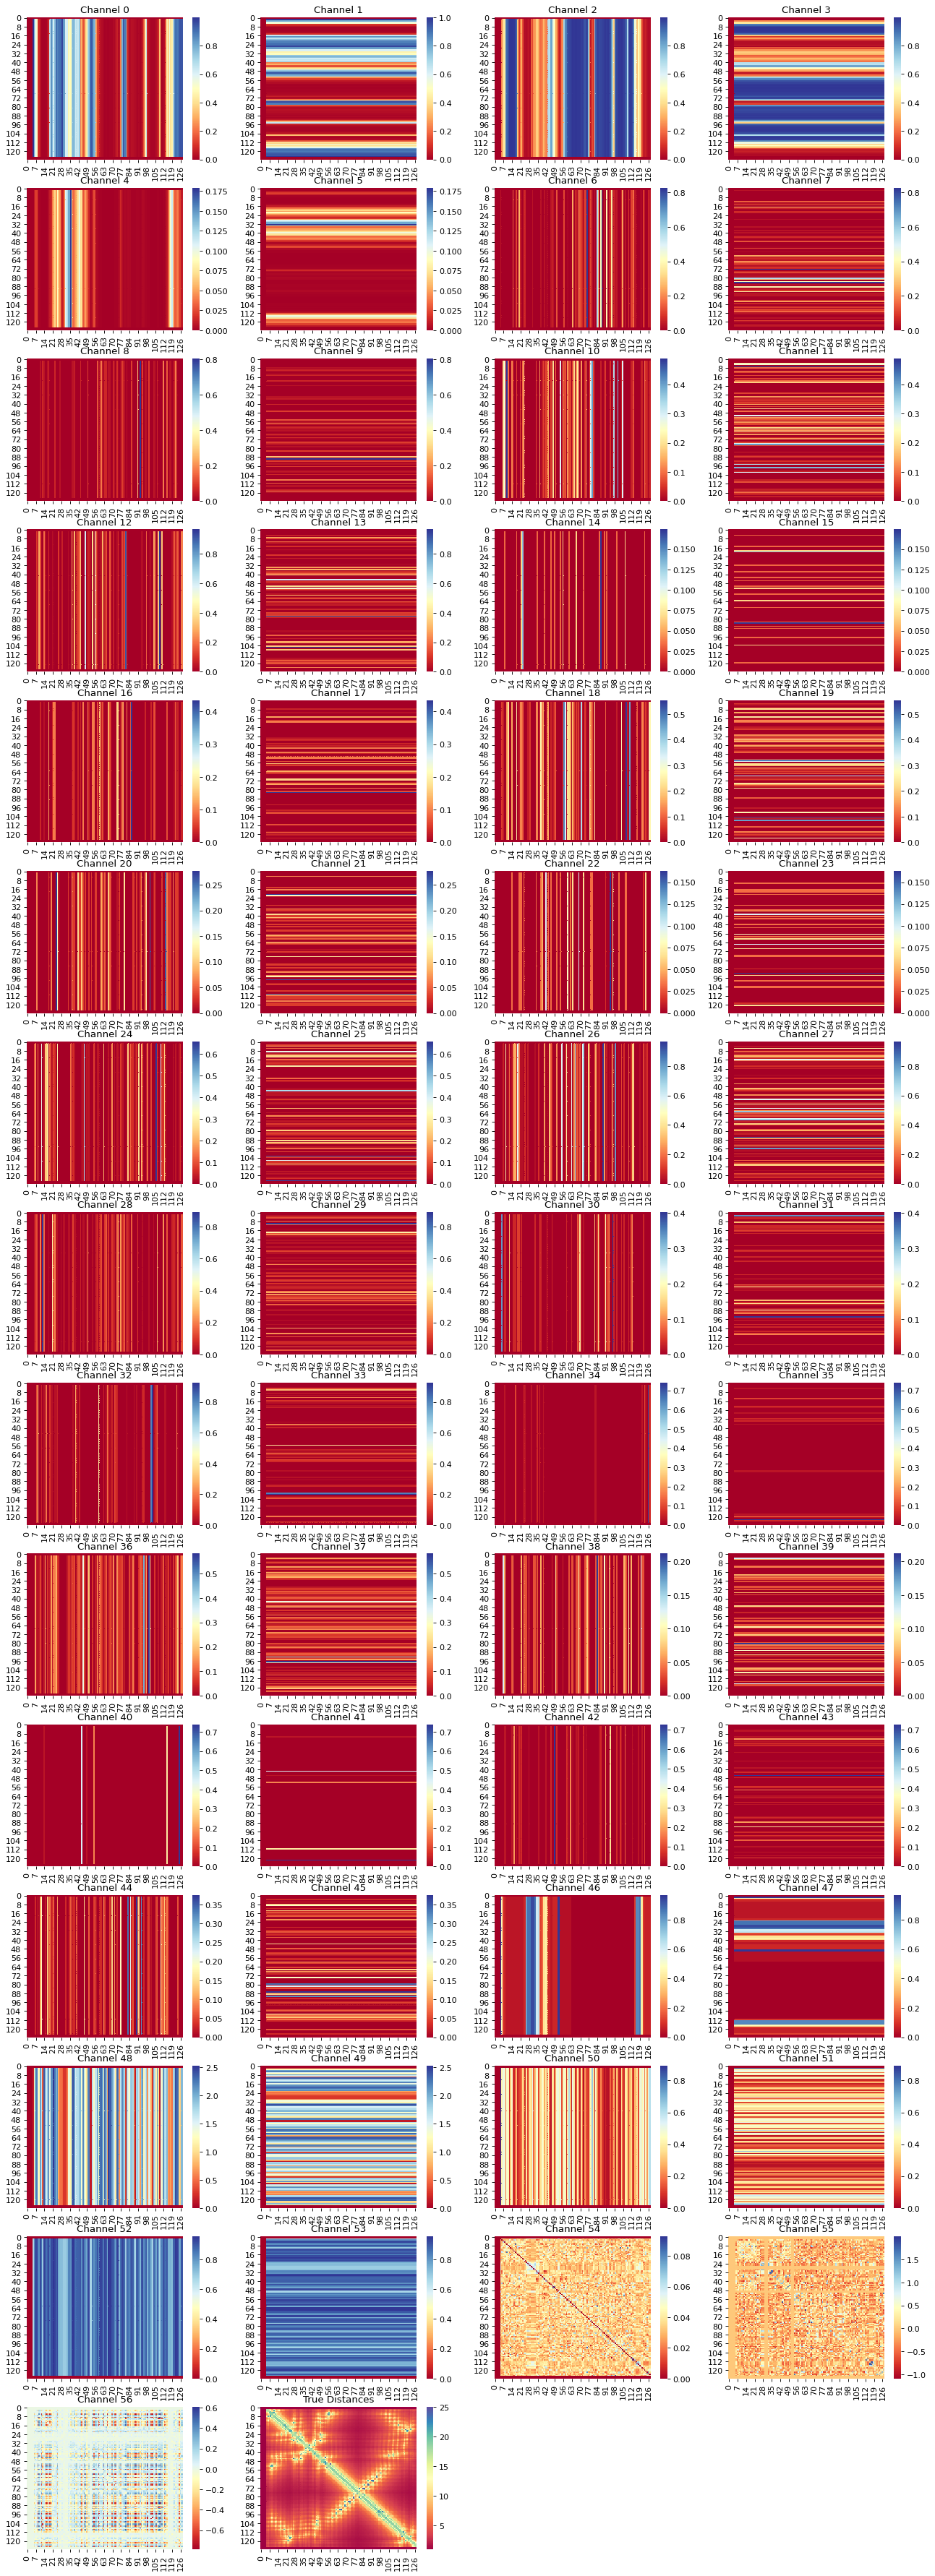


Build a model..

Model params:
L 128
num_blocks 16
width 128
expected_n_channels 57


Compile model..
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 57 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 57) 228         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 57) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 128 7424        activation[0][0]         

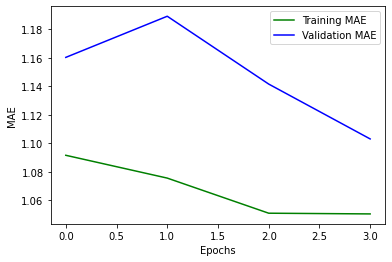


Evaluate validation set..

Model params:
L 512
num_blocks 16
width 128
expected_n_channels 57

Instructions for updating:
Please use Model.predict, which supports generators.
100/100 [==============================] - 59s 587ms/step


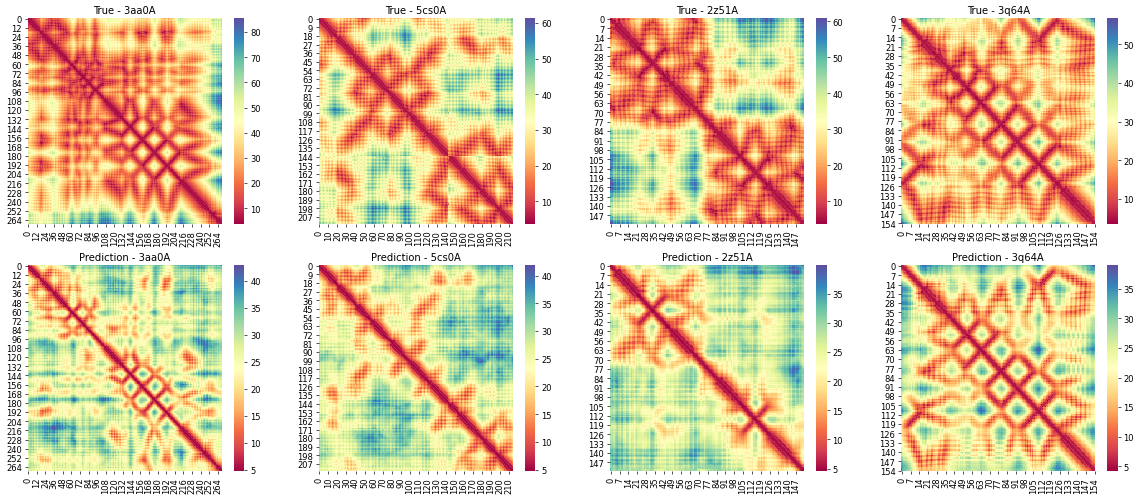


MAE for 0 3aa0A lr_d8 = 9.74  mlr_d8 = 8.72  lr_d12 = 7.85  mlr_d12 = 7.43
MAE for 1 5cs0A lr_d8 = 10.97  mlr_d8 = 10.09  lr_d12 = 8.87  mlr_d12 = 8.01
MAE for 2 2z51A lr_d8 = 12.89  mlr_d8 = 10.23  lr_d12 = 10.10  mlr_d12 = 8.64
MAE for 3 3q64A lr_d8 = 2.63  mlr_d8 = 2.19  lr_d12 = 2.37  mlr_d12 = 2.15
MAE for 4 4p3aA lr_d8 = 10.06  mlr_d8 = 9.36  lr_d12 = 8.55  mlr_d12 = 7.67
MAE for 5 1nkzA lr_d8 = nan  mlr_d8 = nan  lr_d12 = nan  mlr_d12 = 4.91
MAE for 6 4d5tA lr_d8 = 12.60  mlr_d8 = 12.22  lr_d12 = 9.92  mlr_d12 = 9.53
MAE for 7 1jogA lr_d8 = 4.72  mlr_d8 = 4.27  lr_d12 = 3.75  mlr_d12 = 3.40
MAE for 8 4u89A lr_d8 = 11.28  mlr_d8 = 9.44  lr_d12 = 9.31  mlr_d12 = 8.17
MAE for 9 3wisA lr_d8 = 4.62  mlr_d8 = 4.59  lr_d12 = 5.29  mlr_d12 = 5.02
MAE for 10 1mkfA lr_d8 = 13.44  mlr_d8 = 13.02  lr_d12 = 10.42  mlr_d12 = 10.14
MAE for 11 1kaeA lr_d8 = 11.28  mlr_d8 = 10.44  lr_d12 = 9.90  mlr_d12 = 9.04
MAE for 12 4o8bA lr_d8 = 2.17  mlr_d8 = 3.54  lr_d12 = 2.53  mlr_d12 = 3.15
MAE for 1

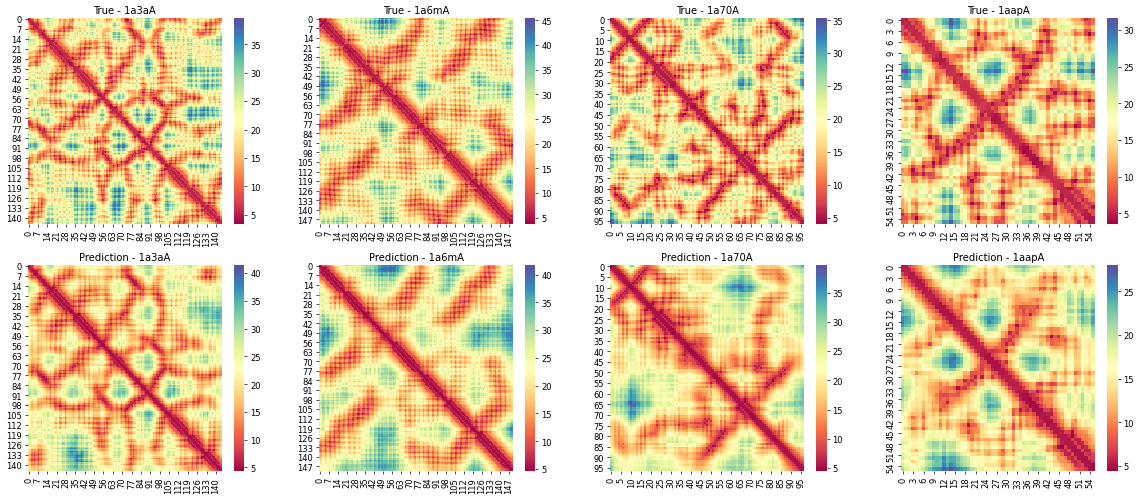


MAE for 0 1a3aA lr_d8 = 3.33  mlr_d8 = 3.05  lr_d12 = 2.98  mlr_d12 = 2.75
MAE for 1 1a6mA lr_d8 = 3.37  mlr_d8 = 3.49  lr_d12 = 2.84  mlr_d12 = 2.96
MAE for 2 1a70A lr_d8 = 5.52  mlr_d8 = 5.13  lr_d12 = 5.68  mlr_d12 = 5.21
MAE for 3 1aapA lr_d8 = 5.15  mlr_d8 = 4.35  lr_d12 = 3.93  mlr_d12 = 3.44
MAE for 4 1abaA lr_d8 = 2.65  mlr_d8 = 3.26  lr_d12 = 2.68  mlr_d12 = 3.00
MAE for 5 1ag6A lr_d8 = 4.90  mlr_d8 = 4.89  lr_d12 = 5.14  mlr_d12 = 5.11
MAE for 6 1aoeA lr_d8 = 4.39  mlr_d8 = 4.19  lr_d12 = 4.25  mlr_d12 = 4.04
MAE for 7 1atlA lr_d8 = 7.20  mlr_d8 = 6.98  lr_d12 = 6.48  mlr_d12 = 6.06
MAE for 8 1atzA lr_d8 = 2.91  mlr_d8 = 2.90  lr_d12 = 2.76  mlr_d12 = 2.65
MAE for 9 1avsA lr_d8 = 7.87  mlr_d8 = 5.94  lr_d12 = 5.70  mlr_d12 = 4.48
MAE for 10 1bdoA lr_d8 = 4.03  mlr_d8 = 3.35  lr_d12 = 3.81  mlr_d12 = 3.37
MAE for 11 1bebA lr_d8 = 8.97  mlr_d8 = 6.92  lr_d12 = 7.16  mlr_d12 = 6.14
MAE for 12 1behA lr_d8 = 7.76  mlr_d8 = 7.48  lr_d12 = 6.46  mlr_d12 = 6.36
MAE for 13 1bkrA lr_d

In [10]:
'''
Author: Badri Adhikari, University of Missouri-St. Louis,  1-25-2020
File: Contains the code to train and test learning real-valued distances, binned-distances and contact maps
'''

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import sys
import numpy as np
import datetime
import argparse
%matplotlib inline

'''
sys.path.insert(0, os.path.dirname(os.path.abspath(sys.argv[0])) + '/lib')
from dataio import *
from metrics import *
from generator import *
from models import *
from losses import *
'''

flag_plots = True

'''
if flag_plots:
    from plots import *
'''

if sys.version_info < (3,0,0):
    print('Python 3 required!!!')
    sys.exit(1)
'''
# Allow GPU memory growth
if hasattr(tf, 'GPUOptions'):
    import keras.backend as K
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    K.tensorflow_backend.set_session(sess)
else:
    # For other GPUs
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

def get_args():
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-t', type=str, required = True, dest = 'type', help="contact/distance/binned")
    parser.add_argument('-w', type=str, required = True, dest = 'file_weights', help="hdf5 weights file")
    parser.add_argument('-n', type=int, required = True, dest = 'num_chains_for_training', help="number of pdbs to use for training (use -1 for ALL)")
    parser.add_argument('-c', type=int, required = True, dest = 'training_window', help="crop size (window) for training, 64, 128, etc. ")
    parser.add_argument('-e', type=int, required = True, dest = 'training_epochs', help="# of epochs")
    parser.add_argument('-d', type=int, required = True, dest = 'arch_depth', help="residual arch depth")
    parser.add_argument('-f', type=int, required = True, dest = 'filters_per_layer', help="number of convolutional filters in each layer")
    parser.add_argument('-p', type=str, required = True, dest = 'dir_dataset', help="path where all the data (including .lst) is located")
    parser.add_argument('-v', type=int, required = True, dest = 'flag_evaluate_only', help="1 = don't train only evaluate")
    parser.add_argument('-o', type=int, required = True, dest = 'flag_evaluate_cameo', help="1 = evaluate on CAMEO-hard dataset as well (takes long)")
    args = parser.parse_args()
    return args

args = get_args()

contact_or_dist_or_binned = args.type
file_weights              = args.file_weights
num_chains_for_training   = args.num_chains_for_training
training_window           = args.training_window
training_epochs           = args.training_epochs
arch_depth                = args.arch_depth
filters_per_layer         = args.filters_per_layer
dir_dataset               = args.dir_dataset
flag_evaluate_only        = False
if args.flag_evaluate_only == 1:
    flag_evaluate_only = True
flag_evaluate_cameo       = False
if args.flag_evaluate_cameo == 1:
    flag_evaluate_cameo = True
pad_size                  = 10
batch_size                = 2
expected_n_channels       = 57
'''

# Parameters for "example" run
contact_or_dist_or_binned = 'distance'
file_weights              = 'distance.hdf5'
num_chains_for_training   = 1000 
training_window           = 128
training_epochs           = 4
arch_depth                = 16
filters_per_layer         = 128
dir_dataset               = './data/'
flag_evaluate_only        = False
flag_evaluate_cameo       = True
pad_size                  = 10
batch_size                = 2
expected_n_channels       = 57

print('Start ' + str(datetime.datetime.now()))

print('')
print('Parameters:')
print('contact_or_dist_or_binned', contact_or_dist_or_binned)
print('num_chains_for_training', num_chains_for_training)
print('file_weights', file_weights)
print('training_window', training_window)
print('training_epochs', training_epochs)
print('arch_depth', arch_depth)
print('filters_per_layer', filters_per_layer)
print('pad_size', pad_size)
print('batch_size', batch_size)
print('dir_dataset', dir_dataset)

if not (contact_or_dist_or_binned == 'distance' or contact_or_dist_or_binned == 'contact' or contact_or_dist_or_binned == 'binned'):
    print('ERROR! Invalid input choice!')
    sys.exit(1)

all_feat_paths = [dir_dataset + '/deepcov/features/', dir_dataset + '/psicov/features/', dir_dataset + '/cameo/features/']
all_dist_paths = [dir_dataset + '/deepcov/distance/', dir_dataset + '/psicov/distance/', dir_dataset + '/cameo/distance/']


bins = {}
if contact_or_dist_or_binned == 'binned':
    bins[0] = '0.0 4.0'
    b = 1
    range_min = float(bins[0].split()[1])
    interval = 0.2
    while(range_min < 8.0):
        bins[b] = str(round(range_min, 2)) + ' ' + str(round(range_min + interval, 2))
        range_min += interval
        b += 1
    while(range_min <= 26):
        interval += 0.2
        bins[b] = str(round(range_min, 2)) + ' ' + str(round(range_min + interval, 2))
        b += 1
        range_min += interval
    bins[b] = '26.0 1000.0'
    print('')
    print('Number of bins', len(bins))
    print('Actual bins:', bins)

deepcov_list = load_list(dir_dataset + '/deepcov.lst', num_chains_for_training)

length_dict = {}
for pdb in deepcov_list:
    (ly, seqy, cb_map) = np.load(dir_dataset + '/deepcov/distance/' + pdb + '-cb.npy', allow_pickle = True)
    length_dict[pdb] = ly

print('')
print('Split into training and validation set..')
valid_pdbs = deepcov_list[:100]
train_pdbs = deepcov_list[100:]

print('Total validation proteins : ', len(valid_pdbs))
print('Total training proteins   : ', len(train_pdbs))

print('')
print('Validation proteins: ', valid_pdbs)

train_generator = ''
valid_generator = ''
if contact_or_dist_or_binned == 'distance':
    train_generator = DistGenerator(train_pdbs, all_feat_paths, all_dist_paths, training_window, pad_size, batch_size, expected_n_channels)
    valid_generator = DistGenerator(valid_pdbs, all_feat_paths, all_dist_paths, training_window, pad_size, batch_size, expected_n_channels)
if contact_or_dist_or_binned == 'contact':
    train_generator = ContactGenerator(train_pdbs, all_feat_paths, all_dist_paths, training_window, pad_size, batch_size, expected_n_channels)
    valid_generator = ContactGenerator(valid_pdbs, all_feat_paths, all_dist_paths, training_window, pad_size, batch_size, expected_n_channels)
if contact_or_dist_or_binned == 'binned':
    train_generator = BinnedDistGenerator(train_pdbs, all_feat_paths, all_dist_paths, bins, training_window, pad_size, batch_size, expected_n_channels)
    valid_generator = BinnedDistGenerator(valid_pdbs, all_feat_paths, all_dist_paths, bins, training_window, pad_size, batch_size, expected_n_channels)

print('')
print('len(train_generator) : ' + str(len(train_generator)))
print('len(valid_generator) : ' + str(len(valid_generator)))

X, Y = train_generator[1]
print('Actual shape of X    : ' + str(X.shape))
print('Actual shape of Y    : ' + str(Y.shape))

print('')
print('Channel summaries:')
summarize_channels(X[0, :, :, :], Y[0])

if flag_plots:
    print('')
    print('Inputs/Output of protein', 0)
    plot_protein_io(X[0, :, :, :], Y[0, :, :, 0])

print('')
print('Build a model..')
model = ''
if contact_or_dist_or_binned == 'distance':
    model = deepcon_rdd_distances(training_window, arch_depth, filters_per_layer, expected_n_channels)
if contact_or_dist_or_binned == 'contact':
    model = deepcon_rdd(training_window, arch_depth, filters_per_layer, expected_n_channels)
if contact_or_dist_or_binned == 'binned':
    model = deepcon_rdd_binned(training_window, arch_depth, filters_per_layer, len(bins), expected_n_channels)

print('')
print('Compile model..')
if contact_or_dist_or_binned == 'distance':
    model.compile(loss = 'logcosh', optimizer = 'rmsprop', metrics = ['mae'])
if contact_or_dist_or_binned == 'contact':
    model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
if contact_or_dist_or_binned == 'binned':
    model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

print(model.summary())

if flag_evaluate_only == 0:
    if contact_or_dist_or_binned == 'binned':
        print('')
        print('Load weights from distance model..')
        distmodel = deepcon_rdd_distances(training_window, arch_depth, filters_per_layer, expected_n_channels)
        distmodel.load_weights('distance256.hdf5')
        for i, layer in enumerate(distmodel.layers):
            print(' Copying weights of layer ', i, layer.name)
            model.layers[i].set_weights(layer.get_weights())
            if layer.name == 'activation_516':
                break
    if os.path.exists(file_weights):
        print('')
        print('Loading existing weights..')
        model.load_weights(file_weights)

    print('')
    print('Train..')

    history = model.fit_generator(generator = train_generator,
        validation_data = valid_generator,
        callbacks = [ModelCheckpoint(filepath = file_weights, monitor = 'val_loss', save_best_only = True, save_weights_only = True, verbose = 1)],
        verbose = 1,
        max_queue_size = 8,
        workers = 1,
        use_multiprocessing = False,
        shuffle = True ,
        epochs = training_epochs)

    if flag_plots:
        plot_learning_curves(history)

LMAX = 512

print('')
print('Evaluate validation set..')

if contact_or_dist_or_binned == 'distance':
    model = deepcon_rdd_distances(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_distance_predictions(model, valid_pdbs, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, False, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'contact':
    model = deepcon_rdd(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_contact_predictions(model, valid_pdbs, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, False, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'binned':
    model = deepcon_rdd_binned(LMAX, arch_depth, filters_per_layer, len(bins), expected_n_channels)
    model.load_weights(file_weights)
    eval_binned_predictions(model, valid_pdbs, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, False, LMAX, bins, expected_n_channels)

print('')
print('Evaluate test set..')

psicov_list = load_list(dir_dataset + 'psicov.lst')

length_dict = {}
for pdb in psicov_list:
    (ly, seqy, cb_map) = np.load(dir_dataset + '/psicov/distance/' + pdb + '-cb.npy', allow_pickle = True)
    length_dict[pdb] = ly

if contact_or_dist_or_binned == 'distance':
    model = deepcon_rdd_distances(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_distance_predictions(model, psicov_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'contact':
    model = deepcon_rdd(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_contact_predictions(model, psicov_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'binned':
    model = deepcon_rdd_binned(LMAX, arch_depth, filters_per_layer, len(bins), expected_n_channels)
    model.load_weights(file_weights)
    eval_binned_predictions(model, psicov_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, bins, expected_n_channels)


In [0]:
print('')
print('Evaluate on CAMEO-HARD set..')

cameo_list = load_list(dir_dataset + 'cameo-hard.lst')

length_dict = {}
for pdb in cameo_list:
    (ly, seqy, cb_map) = np.load(dir_dataset + '/cameo/distance/' + pdb + '-cb.npy', allow_pickle = True)
    length_dict[pdb] = ly

if contact_or_dist_or_binned == 'distance':
    model = deepcon_rdd_distances(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_distance_predictions(model, cameo_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'contact':
    model = deepcon_rdd(LMAX, arch_depth, filters_per_layer, expected_n_channels)
    model.load_weights(file_weights)
    eval_contact_predictions(model, cameo_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, expected_n_channels)

if contact_or_dist_or_binned == 'binned':
    model = deepcon_rdd_binned(LMAX, arch_depth, filters_per_layer, len(bins), expected_n_channels)
    model.load_weights(file_weights)
    eval_binned_predictions(model, cameo_list, length_dict, all_feat_paths, all_dist_paths, pad_size, flag_plots, True, LMAX, bins, expected_n_channels)